In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import time
import copy
import os

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, transforms
import cv2

In [0]:
# Consts
BATCH_SIZE = 32
EPOCHS = 20

In [15]:
#from google.colab import drive
#drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# Set path to the work location
root = 'drive/My Drive/Colab Notebooks/Dataset'

In [12]:
data_root = ''.join([root, '/Dataset'])
print(os.listdir(data_root))

['Real', 'Phone', 'Tablet', 'Paper']


# Data preparation

In [0]:
# Locations to store data
train_dir = 'drive/My Drive/Colab Notebooks/Dataset/train'
val_dir = 'drive/My Drive/Colab Notebooks/Dataset/val'
test_dir = 'drive/My Drive/Colab Notebooks/Dataset/test'

In [95]:
# Split initial data into train, validation and test sets
import shutil 
from tqdm import tqdm

source_names = ['Paper', 'Phone', 'Real', 'Tablet']
class_names = ['Real', 'Fake']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

os.makedirs(''.join([test_dir, '/unknown']), exist_ok=True)
        
for source_name in source_names:
    source_dir = os.path.join(data_root, source_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 == 0:
            if source_name == 'Real':
                dest_dir = os.path.join(val_dir, 'Real')
            else:
                dest_dir = os.path.join(val_dir, 'Fake')                 
        else:
            if (i + 1) % 6 != 0:           
                if source_name == 'Real':
                    dest_dir = os.path.join(train_dir, 'Real')
                else:
                    dest_dir = os.path.join(train_dir, 'Fake')   
            else:
                dest_dir = os.path.join(''.join([test_dir, '/unknown']))
#                if source_name == 'Real':
#                    dest_dir = os.path.join(test_dir, 'Real')
#                else:
#                    dest_dir = os.path.join(test_dir, 'Fake')   
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

  4%|▍         | 14/321 [00:00<00:02, 139.35it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 61


100%|██████████| 215/215 [00:02<00:00, 78.65it/s]


In [0]:
transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = torchvision.datasets.ImageFolder(train_dir, transforms['train'])
val_dataset = torchvision.datasets.ImageFolder(val_dir, transforms['val'])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=BATCH_SIZE)

In [99]:
len(train_dataloader), len(train_dataset)

(37, 1173)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


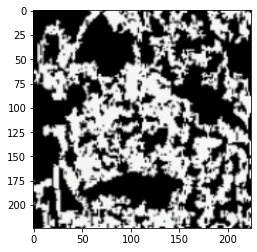

In [100]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

In [101]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

Output hidden; open in https://colab.research.google.com to view.

#Train routine

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs=5):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [0]:
# Let's take pretrained Resnet-34
model = models.resnet34(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

# Add new FC layer to the end
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=1.0e-3, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0e-3)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

In [17]:
train_model(model, loss, optimizer, scheduler, num_epochs=EPOCHS);

Epoch 0/19:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 37/37 [00:07<00:00,  5.19it/s]

train Loss: 0.4647 Acc: 0.7774



100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

val Loss: 0.4047 Acc: 0.8625
Epoch 1/19:



100%|██████████| 37/37 [00:07<00:00,  5.10it/s]

train Loss: 0.2926 Acc: 0.8999



100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

val Loss: 0.2691 Acc: 0.8826
Epoch 2/19:



100%|██████████| 37/37 [00:07<00:00,  5.08it/s]

train Loss: 0.2380 Acc: 0.9146



100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

val Loss: 0.2273 Acc: 0.9250
Epoch 3/19:



100%|██████████| 37/37 [00:07<00:00,  5.20it/s]

train Loss: 0.2017 Acc: 0.9396



100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

val Loss: 0.2329 Acc: 0.8920
Epoch 4/19:



100%|██████████| 37/37 [00:07<00:00,  5.15it/s]

train Loss: 0.2307 Acc: 0.9075



100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

val Loss: 0.1977 Acc: 0.9469
Epoch 5/19:



100%|██████████| 37/37 [00:07<00:00,  5.20it/s]

train Loss: 0.1897 Acc: 0.9286



100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

val Loss: 0.1954 Acc: 0.9375
Epoch 6/19:



100%|██████████| 37/37 [00:07<00:00,  5.00it/s]

train Loss: 0.1711 Acc: 0.9387



100%|██████████| 10/10 [00:02<00:00,  3.75it/s]

val Loss: 0.2067 Acc: 0.8951
Epoch 7/19:



100%|██████████| 37/37 [00:07<00:00,  5.04it/s]

train Loss: 0.1568 Acc: 0.9459



100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

val Loss: 0.1778 Acc: 0.9375
Epoch 8/19:



100%|██████████| 37/37 [00:07<00:00,  5.18it/s]

train Loss: 0.1524 Acc: 0.9455



100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

val Loss: 0.1783 Acc: 0.9201
Epoch 9/19:



100%|██████████| 37/37 [00:07<00:00,  5.08it/s]

train Loss: 0.1433 Acc: 0.9510



100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

val Loss: 0.1696 Acc: 0.9438
Epoch 10/19:



100%|██████████| 37/37 [00:07<00:00,  5.23it/s]

train Loss: 0.1491 Acc: 0.9489



100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

val Loss: 0.1720 Acc: 0.9344
Epoch 11/19:



100%|██████████| 37/37 [00:07<00:00,  5.15it/s]

train Loss: 0.1321 Acc: 0.9531



100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

val Loss: 0.1675 Acc: 0.9406
Epoch 12/19:



100%|██████████| 37/37 [00:07<00:00,  5.25it/s]

train Loss: 0.1515 Acc: 0.9468



100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

val Loss: 0.1686 Acc: 0.9469
Epoch 13/19:



100%|██████████| 37/37 [00:07<00:00,  5.19it/s]

train Loss: 0.1486 Acc: 0.9552



100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

val Loss: 0.1723 Acc: 0.9531
Epoch 14/19:



100%|██████████| 37/37 [00:07<00:00,  5.14it/s]

train Loss: 0.1458 Acc: 0.9497



100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

val Loss: 0.1663 Acc: 0.9375
Epoch 15/19:



100%|██████████| 37/37 [00:06<00:00,  5.34it/s]

train Loss: 0.1610 Acc: 0.9421



100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

val Loss: 0.1684 Acc: 0.9375
Epoch 16/19:



100%|██████████| 37/37 [00:07<00:00,  5.06it/s]

train Loss: 0.1411 Acc: 0.9548



100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

val Loss: 0.1694 Acc: 0.9500
Epoch 17/19:



100%|██████████| 37/37 [00:07<00:00,  5.08it/s]

train Loss: 0.1347 Acc: 0.9527



100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

val Loss: 0.1653 Acc: 0.9375
Epoch 18/19:



100%|██████████| 37/37 [00:07<00:00,  5.18it/s]

train Loss: 0.1377 Acc: 0.9519



100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

val Loss: 0.1654 Acc: 0.9406
Epoch 19/19:



100%|██████████| 37/37 [00:07<00:00,  5.10it/s]

train Loss: 0.1341 Acc: 0.9514



100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

val Loss: 0.1628 Acc: 0.9469


#Get predictions

In [0]:
#test_dir = 'drive/My Drive/Colab Notebooks/Dataset/test'
#test_dir

In [0]:
#ls 'drive/My Drive/Colab Notebooks/Dataset/test/unknown'

In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, transforms['val'])

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [105]:
len(test_dataloader), len(test_dataset)

(10, 291)

In [107]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 291
    Root location: drive/My Drive/Colab Notebooks/Dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [108]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


In [109]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred, path in zip(inputs, test_predictions, paths):
    show_input(img, title='\n'.join([pred.astype(str), path]))

Output hidden; open in https://colab.research.google.com to view.

# Get results and save model

In [110]:
liveness_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
liveness_df['id'] = liveness_df['id'].str.replace(''.join([test_dir, '/unknown/']), '')
liveness_df['id'] = liveness_df['id'].str.replace('.png', '')

ERROR! Session/line number was not unique in database. History logging moved to new session 62


In [111]:
liveness_df.head()

,id,label
0,paper10,0.019676
1,paper108,0.002224
2,paper113,0.062213
3,paper119,0.017305
4,paper126,0.000405


In [112]:
liveness_df['label'] = liveness_df['label'].map(lambda pred: 'real' if pred > 0.5 else 'fake')
liveness_df.set_index('id', inplace=True)
liveness_df.tail(n=10)

,label
id,
tablet44,fake
tablet49,fake
tablet55,fake
tablet57,fake
tablet7,real
tablet71,fake
tablet80,fake
tablet81,fake
tablet89,fake


In [0]:
liveness_df.to_csv(root + '/liveness.csv')

In [0]:
# Save torch model
os.makedirs(''.join([root, '/Models']), exist_ok=True)
torch.save(model.state_dict(), root + '/Models/torch_model.pth')

In [118]:
# Save the converted model (for external use)
X_batch, y_batch = next(iter(train_dataloader))
traced_script_module = torch.jit.trace(model, X_batch.to(device))
traced_script_module.save(root + '/Models/traced_model.pt')

/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1044: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[2, 0] (-0.011799884960055351 vs. -0.01181192509829998) and 0 other locations (1.00%)
  check_tolerance, _force_outplace, True, _module_class)
